In [11]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
#sysはコマンドライン引数
import sys
import csv
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み、一行目はヘッダーじゃない
df = pd.read_csv("input.csv",header=None)
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納
X_size,dimension = X.shape
#クラスタ数宣言
c = 5
#Kはクラスタサイズ 
K = X_size /c
max_iter = 100
cluster = [0 for i in range(10)]
distances=np.zeros((X_size,c))
best_J = 10000

In [19]:
#uの最適化部分関数作成
def u_optimize(d,J):
    #変数定義
    u = [0] * len(d)
    for i in  range (len(d)):
        u[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*u[i]+u[i]*cp.log(u[i])
    
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        #下の式はcの値によって逐次変更しないといけない
        goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u[0:len(d):c])==K)
    goukeigo.append(sum(u[1:len(d):c])==K)
    goukeigo.append(sum(u[2:len(d):c])==K)
    goukeigo.append(sum(u[3:len(d):c])==K)
    goukeigo.append(sum(u[4:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u[i].value)
    u = u_value
    J = np.append(J,result)
    return u,J

#クラスタ中心計算部分関数作成
def v_calculation(u_value):
    u_list = u_value.reshape([99,5])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**8
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**8
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**8
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**8
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**8
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**8*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**8*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**8*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**8*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**8*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

for s in range (10):
    centroids = X[np.random.choice(X_size,c)]
    J = np.empty(0)
    for epoch in range(max_iter):
        #dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
        d=[]
        for i in range(X_size):
            for j in range(c):
                d.append(np.sum((X[i]-centroids[j])**2))
        #uの更新
        optimize_result = u_optimize(d,J)
        u = optimize_result[0]
        J = optimize_result[1]
        #vの更新
        v = v_calculation(u)
        new_centroids = np.array(v)
        new_centroids_kai = new_centroids[::-1,]
        # もしも重心が変わっていなかったら終了
        if (np.allclose(new_centroids, centroids) or np.allclose(new_centroids_kai, centroids)):
            print("中心が変わらないのでbreakします！")
            break
        centroids =  np.copy(new_centroids)
        print(epoch)
        print("回目終了")
    #目的関数が小さくなっている時、cluster,best_J,best_centoridsの更新を行う
    if best_J > J[-1]:
        u_list = u.reshape([99,5])
        np_cluster = np.argmax(u_list,axis=1)
        #最適な目的関数の更新
        best_J = J[-1]
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
    print(s)
    print("回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(np_cluster)
print(best_J)
print(best_centroids)

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
var21482463 @ log(var21482463)
var21482464 @ log(var21482464)
var21482465 @ log(var21482465)
var21482466 @ log(var21482466)
var21482467 @ log(var21482467)
var21482468 @ log(var21482468)
var21482469 @ log(var21482469)
var21482470 @ log(var21482470)
var21482471 @ log(var21482471)
var21482472 @ log(var21482472)
var21482473 @ log(var21482473)
var21482474 @ log(var21482474)
var21482475 @ log(var21482475)
var21482476 @ log(var21482476)
var21482477 @ log(var21482477)
var21482478 @ log(var21482478)
var21482479 @ log(var21482479)
var21482480 @ log(var21482480)
var21482481 @ log(var21482481)
var21482482 @ log(var21482482)
var21482483 @ log(var21482483)
var21482484 @ log(var21482484)
var21482485 @ log(var21482485)
var21482486 @ log(var21482486)
var21482487 @ log(var21482487)
var21482488 @ log(var21482488)
var21482489 @ log(var21482489)
var21482490 @ log(var21482490)
var21482491 @ log(var21482491)
var21482492 @ log(var21482492)
var21482493 @ log(var21482493)
var21482494 @ log(var21482494)
var21482495 @ log(var21482495)
var21482496 @ log(var21482496)
var21482497 @ log(var21482497)
var21482498 @ log(var21482498)
var21482499 @ log(var21482499)
var21482500 @ log(var21482500)
var21482501 @ log(var21482501)
var21482502 @ log(var21482502)
var21482503 @ log(var21482503)
var21482504 @ log(var21482504)
var21482505 @ log(var21482505)
var21482506 @ log(var21482506)
var21482507 @ log(var21482507)
var21482508 @ log(var21482508)
var21482509 @ log(var21482509)
var21482510 @ log(var21482510)
var21482511 @ log(var21482511)
var21482512 @ log(var21482512)
var21482513 @ log(var21482513)
var21482514 @ log(var21482514)
var21482515 @ log(var21482515)
var21482516 @ log(var21482516)
var21482517 @ log(var21482517)
var21482518 @ log(var21482518)
var21482519 @ log(var21482519)
var21482520 @ log(var21482520)
var21482521 @ log(var21482521)
var21482522 @ log(var21482522)
var21482523 @ log(var21482523)
var21482524 @ log(var21482524)
var21482525 @ log(var21482525)
var21482526 @ log(var21482526)
var21482527 @ log(var21482527)
var21482528 @ log(var21482528)
var21482529 @ log(var21482529)
var21482530 @ log(var21482530)
var21482531 @ log(var21482531)
var21482532 @ log(var21482532)
var21482533 @ log(var21482533)
var21482534 @ log(var21482534)
var21482535 @ log(var21482535)
var21482536 @ log(var21482536)
var21482537 @ log(var21482537)
var21482538 @ log(var21482538)
var21482539 @ log(var21482539)
var21482540 @ log(var21482540)
var21482541 @ log(var21482541)
var21482542 @ log(var21482542)
var21482543 @ log(var21482543)
var21482544 @ log(var21482544)
var21482545 @ log(var21482545)
var21482546 @ log(var21482546)
var21482547 @ log(var21482547)
var21482548 @ log(var21482548)
var21482549 @ log(var21482549)
var21482550 @ log(var21482550)
var21482551 @ log(var21482551)
var21482552 @ log(var21482552)
var21482553 @ log(var21482553)
var21482554 @ log(var21482554)
var21482555 @ log(var21482555)
var21482556 @ log(var21482556)
var21482557 @ log(var21482557)
var21482558 @ log(var21482558)
var21482559 @ log(var21482559)
var21482560 @ log(var21482560)
var21482561 @ log(var21482561)
var21482562 @ log(var21482562)
var21482563 @ log(var21482563)
var21482564 @ log(var21482564)
var21482565 @ log(var21482565)
var21482566 @ log(var21482566)
var21482567 @ log(var21482567)
var21482568 @ log(var21482568)
var21482569 @ log(var21482569)
var21482570 @ log(var21482570)
var21482571 @ log(var21482571)
var21482572 @ log(var21482572)
var21482573 @ log(var21482573)
var21482574 @ log(var21482574)
var21482575 @ log(var21482575)
var21482576 @ log(var21482576)
var21482577 @ log(var21482577)
var21482578 @ log(var21482578)
var21482579 @ log(var21482579)
var21482580 @ log(var21482580)
var21482581 @ log(var21482581)
var21482582 @ log(var21482582)
var21482583 @ log(var21482583)
var21482584 @ log(var21482584)
var21482585 @ log(var21482585)
var21482586 @ log(var21482586)
var21482587 @ log(var21482587)
var21482588 @ log(var21482588)
var21482589 @ log(var21482589)
var21482590 @ log(var21482590)
var21482591 @ log(var21482591)
var21482592 @ log(var21482592)
var21482593 @ log(var21482593)
var21482594 @ log(var21482594)
var21482595 @ log(var21482595)
var21482596 @ log(var21482596)
var21482597 @ log(var21482597)
var21482598 @ log(var21482598)
var21482599 @ log(var21482599)
var21482600 @ log(var21482600)
var21482601 @ log(var21482601)
var21482602 @ log(var21482602)
var21482603 @ log(var21482603)
var21482604 @ log(var21482604)
var21482605 @ log(var21482605)
var21482606 @ log(var21482606)
var21482607 @ log(var21482607)
var21482608 @ log(var21482608)
var21482609 @ log(var21482609)
var21482610 @ log(var21482610)
var21482611 @ log(var21482611)
var21482612 @ log(var21482612)
var21482613 @ log(var21482613)
var21482614 @ log(var21482614)
var21482615 @ log(var21482615)
var21482616 @ log(var21482616)
var21482617 @ log(var21482617)
var21482618 @ log(var21482618)
var21482619 @ log(var21482619)
var21482620 @ log(var21482620)
var21482621 @ log(var21482621)
var21482622 @ log(var21482622)
var21482623 @ log(var21482623)
var21482624 @ log(var21482624)
var21482625 @ log(var21482625)
var21482626 @ log(var21482626)
var21482627 @ log(var21482627)
var21482628 @ log(var21482628)
var21482629 @ log(var21482629)
var21482630 @ log(var21482630)
var21482631 @ log(var21482631)
var21482632 @ log(var21482632)
var21482633 @ log(var21482633)
var21482634 @ log(var21482634)
var21482635 @ log(var21482635)
var21482636 @ log(var21482636)
var21482637 @ log(var21482637)
var21482638 @ log(var21482638)
var21482639 @ log(var21482639)
var21482640 @ log(var21482640)
var21482641 @ log(var21482641)
var21482642 @ log(var21482642)
var21482643 @ log(var21482643)
var21482644 @ log(var21482644)
var21482645 @ log(var21482645)
var21482646 @ log(var21482646)
var21482647 @ log(var21482647)
var21482648 @ log(var21482648)
var21482649 @ log(var21482649)
var21482650 @ log(var21482650)
var21482651 @ log(var21482651)
var21482652 @ log(var21482652)
var21482653 @ log(var21482653)
var21482654 @ log(var21482654)
var21482655 @ log(var21482655)
var21482656 @ log(var21482656)
var21482657 @ log(var21482657)
var21482658 @ log(var21482658)
var21482659 @ log(var21482659)
var21482660 @ log(var21482660)
var21482661 @ log(var21482661)
var21482662 @ log(var21482662)
var21482663 @ log(var21482663)
var21482664 @ log(var21482664)
var21482665 @ log(var21482665)
var21482666 @ log(var21482666)
var21482667 @ log(var21482667)
var21482668 @ log(var21482668)
var21482669 @ log(var21482669)
var21482670 @ log(var21482670)
var21482671 @ log(var21482671)
var21482672 @ log(var21482672)
var21482673 @ log(var21482673)
var21482674 @ log(var21482674)
var21482675 @ log(var21482675)
var21482676 @ log(var21482676)
var21482677 @ log(var21482677)
var21482678 @ log(var21482678)
var21482679 @ log(var21482679)
var21482680 @ log(var21482680)
var21482681 @ log(var21482681)
var21482682 @ log(var21482682)
var21482683 @ log(var21482683)
var21482684 @ log(var21482684)
var21482685 @ log(var21482685)
var21482686 @ log(var21482686)
var21482687 @ log(var21482687)
var21482688 @ log(var21482688)
var21482689 @ log(var21482689)
var21482690 @ log(var21482690)
var21482691 @ log(var21482691)
var21482692 @ log(var21482692)
var21482693 @ log(var21482693)
var21482694 @ log(var21482694)
var21482695 @ log(var21482695)
var21482696 @ log(var21482696)
var21482697 @ log(var21482697)
var21482698 @ log(var21482698)
var21482699 @ log(var21482699)
var21482700 @ log(var21482700)
var21482701 @ log(var21482701)
var21482702 @ log(var21482702)
var21482703 @ log(var21482703)
var21482704 @ log(var21482704)
var21482705 @ log(var21482705)
var21482706 @ log(var21482706)
var21482707 @ log(var21482707)
var21482708 @ log(var21482708)
var21482709 @ log(var21482709)
var21482710 @ log(var21482710)
var21482711 @ log(var21482711)
var21482712 @ log(var21482712)
var21482713 @ log(var21482713)
var21482714 @ log(var21482714)
var21482715 @ log(var21482715)
var21482716 @ log(var21482716)
var21482717 @ log(var21482717)
var21482718 @ log(var21482718)
var21482719 @ log(var21482719)
var21482720 @ log(var21482720)
var21482721 @ log(var21482721)
var21482722 @ log(var21482722)
var21482723 @ log(var21482723)
var21482724 @ log(var21482724)
var21482725 @ log(var21482725)
var21482726 @ log(var21482726)
var21482727 @ log(var21482727)
var21482728 @ log(var21482728)
var21482729 @ log(var21482729)
var21482730 @ log(var21482730)
var21482731 @ log(var21482731)
var21482732 @ log(var21482732)
var21482733 @ log(var21482733)
var21482734 @ log(var21482734)
var21482735 @ log(var21482735)
var21482736 @ log(var21482736)
var21482737 @ log(var21482737)
var21482738 @ log(var21482738)
var21482739 @ log(var21482739)
var21482740 @ log(var21482740)
var21482741 @ log(var21482741)
var21482742 @ log(var21482742)
var21482743 @ log(var21482743)
var21482744 @ log(var21482744)
var21482745 @ log(var21482745)
var21482746 @ log(var21482746)
var21482747 @ log(var21482747)
var21482748 @ log(var21482748)
var21482749 @ log(var21482749)
var21482750 @ log(var21482750)
var21482751 @ log(var21482751)
var21482752 @ log(var21482752)
var21482753 @ log(var21482753)
var21482754 @ log(var21482754)
var21482755 @ log(var21482755)
var21482756 @ log(var21482756)
var21482757 @ log(var21482757)
var21482758 @ log(var21482758)
var21482759 @ log(var21482759)
var21482760 @ log(var21482760)
var21482761 @ log(var21482761)
var21482762 @ log(var21482762)
var21482763 @ log(var21482763)
var21482764 @ log(var21482764)
var21482765 @ log(var21482765)
var21482766 @ log(var21482766)
var21482767 @ log(var21482767)
var21482768 @ log(var21482768)
var21482769 @ log(var21482769)
var21482770 @ log(var21482770)
var21482771 @ log(var21482771)
var21482772 @ log(var21482772)
var21482773 @ log(var21482773)
var21482774 @ log(var21482774)
var21482775 @ log(var21482775)
var21482776 @ log(var21482776)
var21482777 @ log(var21482777)
var21482778 @ log(var21482778)
var21482779 @ log(var21482779)
var21482780 @ log(var21482780)
var21482781 @ log(var21482781)
var21482782 @ log(var21482782)
var21482783 @ log(var21482783)
var21482784 @ log(var21482784)
var21482785 @ log(var21482785)
var21482786 @ log(var21482786)
var21482787 @ log(var21482787)
var21482788 @ log(var21482788)
var21482789 @ log(var21482789)
var21482790 @ log(var21482790)
var21482791 @ log(var21482791)
var21482792 @ log(var21482792)
var21482793 @ log(var21482793)
var21482794 @ log(var21482794)
var21482795 @ log(var21482795)
var21482796 @ log(var21482796)
var21482797 @ log(var21482797)
var21482798 @ log(var21482798)
var21482799 @ log(var21482799)
var21482800 @ log(var21482800)
var21482801 @ log(var21482801)
var21482802 @ log(var21482802)
var21482803 @ log(var21482803)
var21482804 @ log(var21482804)
var21482805 @ log(var21482805)
var21482806 @ log(var21482806)
var21482807 @ log(var21482807)
var21482808 @ log(var21482808)
var21482809 @ log(var21482809)
var21482810 @ log(var21482810)
var21482811 @ log(var21482811)
var21482812 @ log(var21482812)
var21482813 @ log(var21482813)
var21482814 @ log(var21482814)
var21482815 @ log(var21482815)
var21482816 @ log(var21482816)
var21482817 @ log(var21482817)
var21482818 @ log(var21482818)
var21482819 @ log(var21482819)
var21482820 @ log(var21482820)
var21482821 @ log(var21482821)
var21482822 @ log(var21482822)
var21482823 @ log(var21482823)
var21482824 @ log(var21482824)
var21482825 @ log(var21482825)
var21482826 @ log(var21482826)
var21482827 @ log(var21482827)
var21482828 @ log(var21482828)
var21482829 @ log(var21482829)
var21482830 @ log(var21482830)
var21482831 @ log(var21482831)
var21482832 @ log(var21482832)
var21482833 @ log(var21482833)
var21482834 @ log(var21482834)
var21482835 @ log(var21482835)
var21482836 @ log(var21482836)
var21482837 @ log(var21482837)
var21482838 @ log(var21482838)
var21482839 @ log(var21482839)
var21482840 @ log(var21482840)
var21482841 @ log(var21482841)
var21482842 @ log(var21482842)
var21482843 @ log(var21482843)
var21482844 @ log(var21482844)
var21482845 @ log(var21482845)
var21482846 @ log(var21482846)
var21482847 @ log(var21482847)
var21482848 @ log(var21482848)
var21482849 @ log(var21482849)
var21482850 @ log(var21482850)
var21482851 @ log(var21482851)
var21482852 @ log(var21482852)
var21482853 @ log(var21482853)
var21482854 @ log(var21482854)
var21482855 @ log(var21482855)
var21482856 @ log(var21482856)
var21482857 @ log(var21482857)
var21482858 @ log(var21482858)
var21482859 @ log(var21482859)
var21482860 @ log(var21482860)
var21482861 @ log(var21482861)
var21482862 @ log(var21482862)
var21482863 @ log(var21482863)
var21482864 @ log(var21482864)
var21482865 @ log(var21482865)
var21482866 @ log(var21482866)
var21482867 @ log(var21482867)
var21482868 @ log(var21482868)
var21482869 @ log(var21482869)
var21482870 @ log(var21482870)
var21482871 @ log(var21482871)
var21482872 @ log(var21482872)
var21482873 @ log(var21482873)
var21482874 @ log(var21482874)
var21482875 @ log(var21482875)
var21482876 @ log(var21482876)
var21482877 @ log(var21482877)
var21482878 @ log(var21482878)
var21482879 @ log(var21482879)
var21482880 @ log(var21482880)
var21482881 @ log(var21482881)
var21482882 @ log(var21482882)
var21482883 @ log(var21482883)
var21482884 @ log(var21482884)
var21482885 @ log(var21482885)
var21482886 @ log(var21482886)
var21482887 @ log(var21482887)
var21482888 @ log(var21482888)
var21482889 @ log(var21482889)
var21482890 @ log(var21482890)
var21482891 @ log(var21482891)
var21482892 @ log(var21482892)
var21482893 @ log(var21482893)
var21482894 @ log(var21482894)
var21482895 @ log(var21482895)
var21482896 @ log(var21482896)
var21482897 @ log(var21482897)
var21482898 @ log(var21482898)
var21482899 @ log(var21482899)
var21482900 @ log(var21482900)
var21482901 @ log(var21482901)
var21482902 @ log(var21482902)
var21482903 @ log(var21482903)
var21482904 @ log(var21482904)
var21482905 @ log(var21482905)
var21482906 @ log(var21482906)
var21482907 @ log(var21482907)
var21482908 @ log(var21482908)
var21482909 @ log(var21482909)
var21482910 @ log(var21482910)
var21482911 @ log(var21482911)
var21482912 @ log(var21482912)
var21482913 @ log(var21482913)
var21482914 @ log(var21482914)
var21482915 @ log(var21482915)
var21482916 @ log(var21482916)
var21482917 @ log(var21482917)
var21482918 @ log(var21482918)
var21482919 @ log(var21482919)
var21482920 @ log(var21482920)
var21482921 @ log(var21482921)
var21482922 @ log(var21482922)
var21482923 @ log(var21482923)
var21482924 @ log(var21482924)
var21482925 @ log(var21482925)
var21482926 @ log(var21482926)
var21482927 @ log(var21482927)
var21482928 @ log(var21482928)
var21482929 @ log(var21482929)
var21482930 @ log(var21482930)
var21482931 @ log(var21482931)
var21482932 @ log(var21482932)
var21482933 @ log(var21482933)
var21482934 @ log(var21482934)
var21482935 @ log(var21482935)
var21482936 @ log(var21482936)
var21482937 @ log(var21482937)
var21482938 @ log(var21482938)
var21482939 @ log(var21482939)
var21482940 @ log(var21482940)
var21482941 @ log(var21482941)
var21482942 @ log(var21482942)
var21482943 @ log(var21482943)
var21482944 @ log(var21482944)
var21482945 @ log(var21482945)
var21482946 @ log(var21482946)
var21482947 @ log(var21482947)
var21482948 @ log(var21482948)
var21482949 @ log(var21482949)
var21482950 @ log(var21482950)
var21482951 @ log(var21482951)
var21482952 @ log(var21482952)
var21482953 @ log(var21482953)
var21482954 @ log(var21482954)
var21482955 @ log(var21482955)
var21482956 @ log(var21482956)
var21482957 @ log(var21482957)

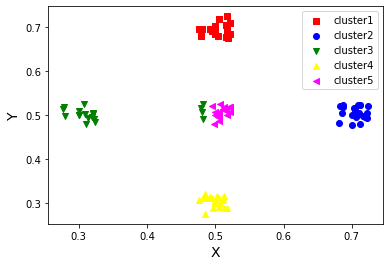

In [14]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i])

#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5'])  # 凡例を表示

plt.show()

fig.savefig("kkt_m=8.pdf")

In [15]:
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))
print(np.count_nonzero(np_cluster==3))
print(np.count_nonzero(np_cluster==4))

21
21
19
21
17


In [247]:
#作業用セル(使用中)(制約条件変更中)（12/13）
centroids = X[np.random.choice(X_size,c)]
#dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
d=[]
for i in range(X_size):
    for j in range(c):
        d.append(np.sum((X[i]-centroids[j])**2))
#uの最適化
u = [0] * len(d)
#変数定義
for i in  range (len(d)):
    u[i] = cp.Variable()
#目的関数定義
Objective_function = 0 
for i  in range(len(d)):
    Objective_function += d[i]*cp.power(u[i],3)
objective = cp.Minimize(Objective_function)
# 制約条件の定義
zeroijou = []
goukeiiti = []
goukeigo = []
constraints = []
#0以上
for i in range (len(d)):
    zeroijou.append(u[i]>=0)
#合計1
for i in range (0,len(d),c):
    #下の式はcの値によって逐次変更しないといけない
    goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
#合計がクラスタサイズ
#下の式はcの値によって逐次変更しないといけない
goukeigo.append(sum(u[0:len(d):c])==K)
goukeigo.append(sum(u[1:len(d):c])==K)
goukeigo.append(sum(u[2:len(d):c])==K)
goukeigo.append(sum(u[3:len(d):c])==K)
goukeigo.append(sum(u[4:len(d):c])==K)
constraints.extend(zeroijou)
constraints.extend(goukeiiti)
constraints.extend(goukeigo)

# 問題を定義
problem = cp.Problem(objective, constraints)
# 最適化 (戻り値は最適化後に得られた値=最小値)
result = problem.solve()

#帰属度uと目的関数Jの値を抽出(ndarray型)
u_value = np.empty(0)#空のndarrayを作成
for i in range (len(d)):
    u_value = np.append(u_value,u[i].value)

u_list = u_value.reshape([99,5])

print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
[19.8 19.8 19.8 19.8 19.8]


In [249]:
#クラスタ中心計算部分関数作成
def v_calculation(u_vallue):
    u_list = u_value.reshape([99,5])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**3
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**3
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**3
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**3
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**3
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**3*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**3*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**3*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

In [250]:
#uの最適化部分関数作成
def u_optimize(d,J):
    #変数定義
    u = [0] * len(d)
    for i in  range (len(d)):
        u[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*cp.power(u[i],3)
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        #下の式はcの値によって逐次変更しないといけない
        goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u[0:len(d):c])==K)
    goukeigo.append(sum(u[1:len(d):c])==K)
    goukeigo.append(sum(u[2:len(d):c])==K)
    goukeigo.append(sum(u[3:len(d):c])==K)
    goukeigo.append(sum(u[4:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u[i].value)
    u = u_value
    J = np.append(J,result)
    return u,J
#クラスタ中心計算部分関数作成
#クラスタ中心計算部分関数作成
def v_calculation(u_value):
    u_list = u_value.reshape([99,5])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**3
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**3
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**3
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**3
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**3
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**3*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**3*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**3*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

In [217]:
v

[array([0.49631367, 0.32719417]),
 array([0.54659171, 0.51736084]),
 array([0.50266058, 0.32294809]),
 array([0.50835673, 0.68137432]),
 array([0.49897542, 0.51704361])]